In [ ]:
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
import numpy as np
import os
from PIL import Image
import PIL

vgg = VGG19(include_top=False, weights='imagenet')
max_image_size = 512

#Last conv layer because it contains most of the information about the content
content_layers = ['block5_conv2'] 

#Getting information about style, we will use these later 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [ ]:
def load_image(image_path):
  image_string = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image_string, channels=3)
  image = tf.image.resize(image, [512, 512])
  return image

In [ ]:
def get_style_extractor():
    style_output_tensors = [vgg.get_layer(layer).output for layer in style_layers]
    style_model = tf.keras.models.Model(inputs=vgg.input, outputs=style_output_tensors)
    return style_model

def get_content_extractor():
    content_output_tensors = [vgg.get_layer(layer).output for layer in content_layers]
    content_model = tf.keras.models.Model(inputs=vgg.input, outputs=content_output_tensors)
    return content_model

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
def eqm(tensors1, tensors2):
  """Calculate the squared mean error"""
  mean = 0
  for i in range(len(tensors1)):
    diff = tf.subtract(tensors1[i], tensors2[i])
    square_diff = tf.square(diff)
    mean += tf.reduce_mean(square_diff)
  return (1/len(tensors1))*mean

In [ ]:
def eval(output_path, content_path, style_path):
  
  content_image = load_image(content_path)
  result_image = load_image(output_path)
  style_image = load_image(style_path)

  style_image = style_image[tf.newaxis, :]
  content_image = content_image[tf.newaxis, :]
  result_image = result_image[tf.newaxis, :]

  style_extractor = get_style_extractor()
  input_style = style_extractor(preprocess_input(style_image * 255))
  input_style = [gram_matrix(input) for input in input_style]
  result_style = style_extractor(preprocess_input(result_image * 255))
  result_style = [gram_matrix(result) for result in result_style]

  content_extractor = get_content_extractor()
  input_content = content_extractor(preprocess_input(content_image * 255))
  result_content = content_extractor(preprocess_input(result_image * 255))

  content_diff = eqm(input_content, result_content)
  style_diff = eqm(input_style, result_style)

  return (content_diff.numpy(), style_diff.numpy())


In [ ]:
def main():
  # content_image = load_image("./eval_inputs_content/01grenoble.jpeg")
  # style_image = load_image("./eval_inputs_style/01picasso.jpeg")
  # result_image = load_image("./eval_outputs/eval_outputs_diy/01grenoble.jpeg--01picasso.jpeg")

  OUTPUT_FOLDER_VGG = "./eval_outputs/eval_outputs_vgg/"
  OUTPUT_FOLDER_VAE = "./eval_outputs/eval_outputs_vae/"
  OUTPUT_FOLDER_DIY = "./eval_outputs/eval_outputs_diy/"
  CONTENT_INPUT_FOLDER = "./eval_inputs_content/"
  STYLE_INPUT_FOLDER = "./eval_inputs_style/"

  content_paths = []
  for dirpath, dirnames, filenames in os.walk(CONTENT_INPUT_FOLDER):
      for file in filenames:
          content_paths.append(os.path.join(dirpath, file))
  style_paths = []
  for dirpath, dirnames, filenames in os.walk(STYLE_INPUT_FOLDER):
      for file in filenames:
          style_paths.append(os.path.join(dirpath, file))
  output_paths_vgg = []
  for dirpath, dirnames, filenames in os.walk(OUTPUT_FOLDER_VGG):
      for file in filenames:
          output_paths_vgg.append(os.path.join(dirpath, file))
  output_paths_vae = []
  for dirpath, dirnames, filenames in os.walk(OUTPUT_FOLDER_VAE):
      for file in filenames:
          output_paths_vae.append(os.path.join(dirpath, file))
  output_paths_diy = []
  for dirpath, dirnames, filenames in os.walk(OUTPUT_FOLDER_DIY):
      for file in filenames:
          output_paths_diy.append(os.path.join(dirpath, file))

  content_paths = sorted(content_paths)
  style_paths = sorted(style_paths)
  output_paths_vgg = sorted(output_paths_vgg)
  output_paths_vae = sorted(output_paths_vae)
  output_paths_diy = sorted(output_paths_diy)

  vgg_results = []
  vae_results = []
  diy_results = []

  for i in range(len(output_paths_vgg)):
    vgg_results.append(eval(output_paths_vgg[i], content_paths[i], style_paths[i]))

  for i in range(len(output_paths_vae)):
    vae_results.append(eval(output_paths_vae[i], content_paths[i], style_paths[i]))

  for i in range(len(output_paths_diy)):
    diy_results.append(eval(output_paths_diy[i], content_paths[i], style_paths[i]))
  print("Vgg :", vgg_results)
  print("Vae :", vae_results)
  print("Diy :", diy_results)

  vgg_content_mean = 0
  vgg_style_mean = 0
  for res in vgg_results:
    vgg_content_mean += res[0]
    vgg_style_mean += res[1]
  vgg_content_mean *= 1/len(vgg_results)
  vgg_style_mean *= 1/len(vgg_results)

  vae_content_mean = 0
  vae_style_mean = 0
  for res in vae_results:
    vae_content_mean += res[0]
    vae_style_mean += res[1]
  vae_content_mean *= 1/len(vae_results)
  vae_style_mean *= 1/len(vae_results)

  diy_content_mean = 0
  diy_style_mean = 0
  for res in diy_results:
    diy_content_mean += res[0]
    diy_style_mean += res[1]
  diy_content_mean *= 1/len(diy_results)
  diy_style_mean *= 1/len(diy_results)

  print(vgg_content_mean)
  print(vae_content_mean)
  print(diy_content_mean)
  
  print(vgg_style_mean)
  print(vae_style_mean)
  print(diy_style_mean)


In [ ]:
if __name__ == "__main__":
  main()

Vgg : [(353050600.0, 2.01028e+20), (363103040.0, 3.092879e+20), (526547000.0, 5.5005963e+19), (172937360.0, 9.132834e+19)]
Vae : [(286272640.0, 1.40804365e+20), (296854460.0, 7.4922157e+18), (310602180.0, 1.2246313e+19), (169437280.0, 4.3806857e+19)]
Diy : [(350091300.0, 2.8596107e+20), (380271300.0, 6.4661804e+20), (309556380.0, 5.326861e+20), (212256740.0, 1.4098715e+20)]
353909500.0
265791640.0
313043928.0
1.641625527987701e+20
5.108743765568468e+19
4.015630935376066e+20


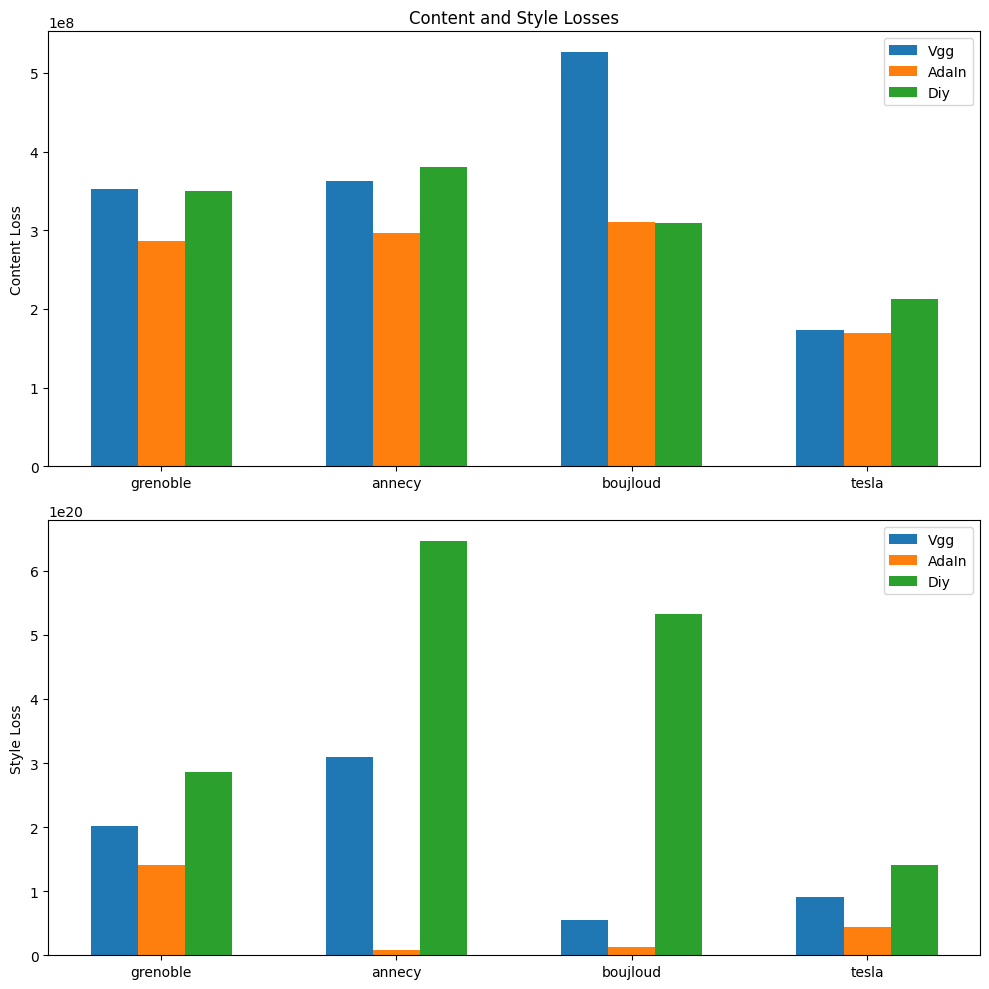

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Vgg = [(353050600.0, 2.01028e+20), (363103040.0, 3.092879e+20), (526547000.0, 5.5005963e+19), (172937360.0, 9.132834e+19)]
Vae = [(286272640.0, 1.40804365e+20), (296854460.0, 7.4922157e+18), (310602180.0, 1.2246313e+19), (169437280.0, 4.3806857e+19)]
Diy = [(350091300.0, 2.8596107e+20), (380271300.0, 6.4661804e+20), (309556380.0, 5.326861e+20), (212256740.0, 1.4098715e+20)]

# Unpack the tuples into separate lists
Vgg_content, Vgg_style = zip(*Vgg)
Vae_content, Vae_style = zip(*Vae)
Diy_content, Diy_style = zip(*Diy)

labels = ['grenoble', 'annecy', 'boujloud', 'tesla']

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(2, 1, figsize=(10,10))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('Content Loss')
ax[0].set_title('Content and Style Losses')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].bar(x - width, Vgg_content, width, label='Vgg')
ax[0].bar(x, Vae_content, width, label='AdaIn')
ax[0].bar(x + width, Diy_content, width, label='Diy')

ax[1].set_ylabel('Style Loss')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].bar(x - width, Vgg_style, width, label='Vgg')
ax[1].bar(x, Vae_style, width, label='AdaIn')
ax[1].bar(x + width, Diy_style, width, label='Diy')

# Add a legend
ax[0].legend()
ax[1].legend()

fig.tight_layout()

plt.show()
plt.savefig("results.png")
